Notebook prepared by Henrique Lopes Cardoso (hlc@fe.up.pt), based on [Word2Vec Tutorial Notebook](https://github.com/kavgan/nlp-in-practice/tree/master/word2vec) by Kavita Ganesan and on [Gensim's documentation on the Word2Vec Model](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html).

# WORD EMBEDDINGS

## Word2Vec in Gensim

[Word2Vec](https://code.google.com/archive/p/word2vec/) is a model for training word embeddings that revolutionized the way words are represented. [Gensim](https://radimrehurek.com/gensim_3.8.3/models/word2vec.html) provides an implementation of the algorithm, with which we can train our own word embeddings.

#### The data

Training embeddings requires a big corpus, the bigger the better.

For illustration purposes, we'll make use of the (not very big) [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset, which includes full reviews of cars and hotels. More specifically, we'll use an 84MB compressed file with 255404 hotel reviews.

This is how each review looks like:

In [1]:
import gzip

data_file = "reviews_data.txt.gz"

with gzip.open('reviews_data.txt.gz', 'rb') as f:
    for i, line in enumerate(f):
        print(line)
        break


b"Oct 12 2009 \tNice trendy hotel location not too bad.\tI stayed in this hotel for one night. As this is a fairly new place some of the taxi drivers did not know where it was and/or did not want to drive there. Once I have eventually arrived at the hotel, I was very pleasantly surprised with the decor of the lobby/ground floor area. It was very stylish and modern. I found the reception's staff geeting me with 'Aloha' a bit out of place, but I guess they are briefed to say that to keep up the coroporate image.As I have a Starwood Preferred Guest member, I was given a small gift upon-check in. It was only a couple of fridge magnets in a gift box, but nevertheless a nice gesture.My room was nice and roomy, there are tea and coffee facilities in each room and you get two complimentary bottles of water plus some toiletries by 'bliss'.The location is not great. It is at the last metro stop and you then need to take a taxi, but if you are not planning on going to see the historic sites in Be

Let's read the whole dataset into a list, while providing some logging information.

In the process of reading the data directly from the compressed file, we'll perform some pre-processing of the reviews using [gensim.utils.simple_preprocess](https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html). This does some basic pre-processing such as tokenization and lowercasing, and returns back a list of tokens (words).

In [3]:
import gensim
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def read_input(input_file):
    """This method reads the input file which is in gzip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file))
    
    with gzip.open(input_file, 'rb') as f:
        for i, line in enumerate (f): 

            if (i%10000==0):
                logging.info ("read {0} reviews".format (i))
            # do some pre-processing and return a list of words for each review text
            yield gensim.utils.simple_preprocess(line)
    logging.info("Done reading data file")

In [4]:
# compressed file with the data
data_file="reviews_data.txt.gz"

# read the tokenized reviews into a list
documents = list(read_input(data_file))

len(documents)

2022-04-13 19:24:45,604 : INFO : reading file reviews_data.txt.gz...this may take a while
2022-04-13 19:24:45,606 : INFO : read 0 reviews
2022-04-13 19:24:46,574 : INFO : read 10000 reviews
2022-04-13 19:24:47,538 : INFO : read 20000 reviews
2022-04-13 19:24:48,645 : INFO : read 30000 reviews
2022-04-13 19:24:49,700 : INFO : read 40000 reviews
2022-04-13 19:24:50,867 : INFO : read 50000 reviews
2022-04-13 19:24:52,159 : INFO : read 60000 reviews
2022-04-13 19:24:53,112 : INFO : read 70000 reviews
2022-04-13 19:24:53,972 : INFO : read 80000 reviews
2022-04-13 19:24:54,879 : INFO : read 90000 reviews
2022-04-13 19:24:55,761 : INFO : read 100000 reviews
2022-04-13 19:24:56,650 : INFO : read 110000 reviews
2022-04-13 19:24:57,532 : INFO : read 120000 reviews
2022-04-13 19:24:58,428 : INFO : read 130000 reviews
2022-04-13 19:24:59,450 : INFO : read 140000 reviews
2022-04-13 19:25:00,352 : INFO : read 150000 reviews
2022-04-13 19:25:04,299 : INFO : read 160000 reviews
2022-04-13 19:25:05,209

255404

Each review item becomes a list of words, so what we have is a list of lists.

In [5]:
print(documents[0])

['oct', 'nice', 'trendy', 'hotel', 'location', 'not', 'too', 'bad', 'stayed', 'in', 'this', 'hotel', 'for', 'one', 'night', 'as', 'this', 'is', 'fairly', 'new', 'place', 'some', 'of', 'the', 'taxi', 'drivers', 'did', 'not', 'know', 'where', 'it', 'was', 'and', 'or', 'did', 'not', 'want', 'to', 'drive', 'there', 'once', 'have', 'eventually', 'arrived', 'at', 'the', 'hotel', 'was', 'very', 'pleasantly', 'surprised', 'with', 'the', 'decor', 'of', 'the', 'lobby', 'ground', 'floor', 'area', 'it', 'was', 'very', 'stylish', 'and', 'modern', 'found', 'the', 'reception', 'staff', 'geeting', 'me', 'with', 'aloha', 'bit', 'out', 'of', 'place', 'but', 'guess', 'they', 'are', 'briefed', 'to', 'say', 'that', 'to', 'keep', 'up', 'the', 'coroporate', 'image', 'as', 'have', 'starwood', 'preferred', 'guest', 'member', 'was', 'given', 'small', 'gift', 'upon', 'check', 'in', 'it', 'was', 'only', 'couple', 'of', 'fridge', 'magnets', 'in', 'gift', 'box', 'but', 'nevertheless', 'nice', 'gesture', 'my', 'room

#### Training the Word2Vec model

To train a Word2Vec model, we instantiate Word2Vec and pass it the text we have loaded before. You can check the available options for [instantiation](https://radimrehurek.com/gensim_3.8.3/models/word2vec.html#gensim.models.word2vec.Word2Vec) and for [training](https://radimrehurek.com/gensim_3.8.3/models/word2vec.html#gensim.models.word2vec.Word2Vec.train).

Training a Word2Vec model takes time, depending on your hardware. In this particular case, expect training to take something between 5 to 10 minutes on an Intel Core-i7 16GB desktop. I know, that's a very wide range, but of course it depends on which other processes are running in the same machine...

In [6]:
from datetime import datetime

start_time = datetime.now()

model = gensim.models.Word2Vec(documents, vector_size=150, window=10, min_count=2, workers=10, sg=1)

print("Training time:", datetime.now() - start_time)

2022-04-13 19:48:36,145 : INFO : collecting all words and their counts
2022-04-13 19:48:36,146 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-04-13 19:48:36,349 : INFO : PROGRESS: at sentence #10000, processed 1655714 words, keeping 25777 word types
2022-04-13 19:48:36,527 : INFO : PROGRESS: at sentence #20000, processed 3317863 words, keeping 35016 word types
2022-04-13 19:48:36,758 : INFO : PROGRESS: at sentence #30000, processed 5264072 words, keeping 47518 word types
2022-04-13 19:48:36,993 : INFO : PROGRESS: at sentence #40000, processed 7081746 words, keeping 56675 word types
2022-04-13 19:48:37,239 : INFO : PROGRESS: at sentence #50000, processed 9089491 words, keeping 63744 word types
2022-04-13 19:48:37,470 : INFO : PROGRESS: at sentence #60000, processed 11013727 words, keeping 76787 word types
2022-04-13 19:48:37,671 : INFO : PROGRESS: at sentence #70000, processed 12637529 words, keeping 83200 word types
2022-04-13 19:48:37,865 : INFO : PROG

Training time: 0:06:25.705325


#### Exploiting the Word2Vec model

We can now inspect the word embeddings that we have trained. We can start by looking at the embeddings of a specific word:

In [7]:
# embeddings
model.wv.get_vector("dirty")

array([-0.12106226,  0.33739045, -0.24111156,  0.14633438, -0.25904828,
       -0.00920367, -0.06131919,  0.5017954 , -0.04270304,  0.12032945,
       -0.00258901,  0.18495153,  0.09007717, -0.00287786, -0.3836427 ,
       -0.47006226, -0.10753492,  0.09861175, -0.35135353, -0.03491545,
        0.21512093,  0.0569086 , -0.1623219 ,  0.268995  ,  0.13661268,
       -0.17064124, -0.14626904,  0.18791728, -0.25276044,  0.11885193,
        0.01131065,  0.37854233, -0.11055728, -0.28835586, -0.18173747,
       -0.01929015,  0.36101308, -0.39397696, -0.08960969, -0.19335432,
        0.5435925 ,  0.03191932, -0.29726845, -0.43226165, -0.23146586,
       -0.08394211,  0.14175497,  0.11351872, -0.04086443,  0.01268723,
       -0.28935584,  0.09050785, -0.34647614,  0.19550245, -0.04698835,
        0.22527452,  0.16180886,  0.26481518, -0.15137435, -0.265002  ,
        0.07746117,  0.11750985, -0.23705469,  0.06652558,  0.14842092,
       -0.10409425, -0.45004442, -0.01271718, -0.25406656,  0.08

Which are the words most similar to this one?

In [14]:
# similarity
w1 = "dirty"
model.wv.most_similar(positive=w1)

[('filthy', 0.8840414881706238),
 ('unclean', 0.8319694399833679),
 ('smelly', 0.8294471502304077),
 ('dusty', 0.8254819512367249),
 ('stained', 0.8246896266937256),
 ('dingy', 0.8034701347351074),
 ('grimy', 0.7924567461013794),
 ('grubby', 0.787903904914856),
 ('disgusting', 0.779763400554657),
 ('unkempt', 0.7652968168258667)]

You can also limit to a smaller number of hits:

In [15]:
# look up top 6 words similar to 'polite'
w1 = ["polite"]
model.wv.most_similar(positive=w1, topn=6)

[('courteous', 0.9056073427200317),
 ('professional', 0.8581145405769348),
 ('efficient', 0.8253434896469116),
 ('attentive', 0.8243843913078308),
 ('curtious', 0.8120770454406738),
 ('curteous', 0.8065165877342224)]

In [16]:
# look up top 6 words similar to 'france'
w1 = ["france"]
model.wv.most_similar(positive=w1, topn=6)

[('germany', 0.7074711322784424),
 ('england', 0.6895706057548523),
 ('spain', 0.6778306365013123),
 ('europe', 0.6580362319946289),
 ('paris', 0.6416419148445129),
 ('ukraine', 0.622798502445221)]

We can also provide to *most_similar* not only positive concepts, but also negative ones. This allows us to do some arithmetic on the vector representations for certain sets of words!

The famous example **king - man + woman = queen** goes as follows:

In [17]:
# arithmetic: vec(“king”) - vec(“man”) + vec(“woman”) =~ vec(“queen”)
w1 = ["king",'woman']
w2 = ['man']
model.wv.most_similar(positive=w1, negative=w2, topn=1)

[('queen', 0.7652041912078857)]

We can get the similarity scores for specific word pairs.

In [18]:
# similarity between two different words
model.wv.similarity(w1="dirty", w2="smelly")

0.82944715

In [19]:
# similarity between two identical words
model.wv.similarity(w1="dirty", w2="dirty")

1.0

In [20]:
# similarity between two unrelated words
model.wv.similarity(w1="dirty", w2="clean")

0.35614142

And we can check which word in a list of words is an intruder:

In [21]:
model.wv.doesnt_match(["cat", "dog", "france"])

'france'

In [22]:
model.wv.doesnt_match(["bed", "pillow", "duvet", "shower"])

'shower'

In [23]:
model.wv.doesnt_match(["car", "bicycle", "plane", "skate"])

'plane'

In [24]:
model.wv.doesnt_match(["car", "bicycle", "bus", "trolley"])

'bicycle'

Make your own experiments! Try to find out:
- Which word is most similar to *lift*?
- What are the 3 words most similar to *crab*?
- How similar are the words *waitress* and *waiter*?
- If you take *portugal*, remove *lisbon*, and add *dublin*, what do you get?

In [26]:
# most similar to lift
model.wv.most_similar(positive=["lift"], topn=1)

[('lifts', 0.8275881409645081)]

In [27]:
# top 3 words most similar to crab
model.wv.most_similar(positive=["crab"], topn=3)

[('chowder', 0.7657322287559509),
 ('oysters', 0.7562358975410461),
 ('shrimp', 0.7560434937477112)]

In [28]:
# how similar are the words waitress and waiter
model.wv.similarity("waitress", "waiter")

0.8781294

In [29]:
# if you take portugal, remove lisbon, and add dublin, what do you get?
model.wv.most_similar(positive=["portugal", "dublin"], negative=["lisbon"], topn=1)

[('ireland', 0.6101027131080627)]

#### Saving and loading a Word2Vec model

You can save a trained model so that you are able to load it again in the future, and optionally continue training it.

In [30]:
# save full model (including trainable vectors to resume training)
model.save("reviews_model")

2022-04-13 20:02:44,103 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'reviews_model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-04-13T20:02:44.103592', 'gensim': '4.1.2', 'python': '3.9.10 (main, Jan 15 2022, 11:40:53) \n[Clang 13.0.0 (clang-1300.0.29.3)]', 'platform': 'macOS-12.3.1-arm64-arm-64bit', 'event': 'saving'}
2022-04-13 20:02:44,106 : INFO : storing np array 'vectors' to reviews_model.wv.vectors.npy
2022-04-13 20:02:44,204 : INFO : storing np array 'syn1neg' to reviews_model.syn1neg.npy
2022-04-13 20:02:44,299 : INFO : not storing attribute cum_table
2022-04-13 20:02:44,568 : INFO : saved reviews_model


In [31]:
# load full model
model = gensim.models.Word2Vec.load("reviews_model")

2022-04-13 20:02:50,995 : INFO : loading Word2Vec object from reviews_model
2022-04-13 20:02:51,010 : INFO : loading wv recursively from reviews_model.wv.* with mmap=None
2022-04-13 20:02:51,010 : INFO : loading vectors from reviews_model.wv.vectors.npy with mmap=None
2022-04-13 20:02:51,043 : INFO : loading syn1neg from reviews_model.syn1neg.npy with mmap=None
2022-04-13 20:02:51,064 : INFO : setting ignored attribute cum_table to None
2022-04-13 20:02:51,320 : INFO : Word2Vec lifecycle event {'fname': 'reviews_model', 'datetime': '2022-04-13T20:02:51.320332', 'gensim': '4.1.2', 'python': '3.9.10 (main, Jan 15 2022, 11:40:53) \n[Clang 13.0.0 (clang-1300.0.29.3)]', 'platform': 'macOS-12.3.1-arm64-arm-64bit', 'event': 'loaded'}


#### Saving and loading the word embeddings

If you're sure you won't be training the model any longer, you can save its *KeyedVectors* (the word embeddings).

In [32]:
# save model word vectors
model.wv.save("reviews_wv")

2022-04-13 20:13:43,015 : INFO : KeyedVectors lifecycle event {'fname_or_handle': 'reviews_wv', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-04-13T20:13:43.015690', 'gensim': '4.1.2', 'python': '3.9.10 (main, Jan 15 2022, 11:40:53) \n[Clang 13.0.0 (clang-1300.0.29.3)]', 'platform': 'macOS-12.3.1-arm64-arm-64bit', 'event': 'saving'}
2022-04-13 20:13:43,017 : INFO : storing np array 'vectors' to reviews_wv.vectors.npy
2022-04-13 20:13:43,125 : INFO : saved reviews_wv


After saving the embeddings, you can load them and use them.

In [33]:
# load model word vectors
wv = gensim.models.KeyedVectors.load("reviews_wv")

print(wv.most_similar(positive="lift", topn=1))

2022-04-13 20:14:24,032 : INFO : loading KeyedVectors object from reviews_wv
2022-04-13 20:14:24,046 : INFO : loading vectors from reviews_wv.vectors.npy with mmap=None
2022-04-13 20:14:24,067 : INFO : KeyedVectors lifecycle event {'fname': 'reviews_wv', 'datetime': '2022-04-13T20:14:24.067554', 'gensim': '4.1.2', 'python': '3.9.10 (main, Jan 15 2022, 11:40:53) \n[Clang 13.0.0 (clang-1300.0.29.3)]', 'platform': 'macOS-12.3.1-arm64-arm-64bit', 'event': 'loaded'}


[('lifts', 0.8275881409645081)]


## Visualization

Word embeddings can be visualized by reducing dimensionality of the words to 2 dimensions using [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

Given enough training data, we can observe certain patterns in the vector space, including:
- Semantic relations: words like *cat*, *dog*, *cow*, etc. have a tendency to lie close by.
- Syntactic relations: words like *run*, *running* or *cut*, *cutting* lie close together.
- Arithmetic properties such as *King - Man = Queen - Woman*.

In [34]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import random


def reduce_dimensions(model, num_dimensions=2, words=[]):

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    word_count = 0
    
    # if no word list is given, assume we want to use the whole data in the model
    if(words == []):
        words = model.wv.index_to_key

    for word in words:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels


# 2 dimension plotting
def plot_with_matplotlib(x_vals, y_vals, labels, words=[]):

    random.seed(0)
    
    x_vals_new = np.array([])
    y_vals_new = np.array([])
    labels_new = np.array([])
    if(words == []):
        # if no word list is given, assume we want to plot the whole data
        x_vals_new = x_vals
        y_vals_new = y_vals
        labels_new = labels
    else:
        for i in range(len(labels)):
            if(labels[i] in words):
                x_vals_new = np.append(x_vals_new,x_vals[i])
                y_vals_new = np.append(y_vals_new,y_vals[i])
                labels_new = np.append(labels_new,labels[i])
    
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals_new, y_vals_new)

    # apply labels
    for i in range(len(labels_new)):
        plt.annotate(labels_new[i], (x_vals_new[i], y_vals_new[i]))
    
    plt.show()

In [35]:
words = []
words.extend(["king", "man", "queen", "woman"])

vectors, labels = reduce_dimensions(model, 2, words)
x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]
print(x_vals, y_vals, labels)

[269.5624, 1.7829943, 220.81143, 50.533993] [-124.8034, -295.07968, -343.83212, -76.050934] ['king' 'man' 'queen' 'woman']


/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


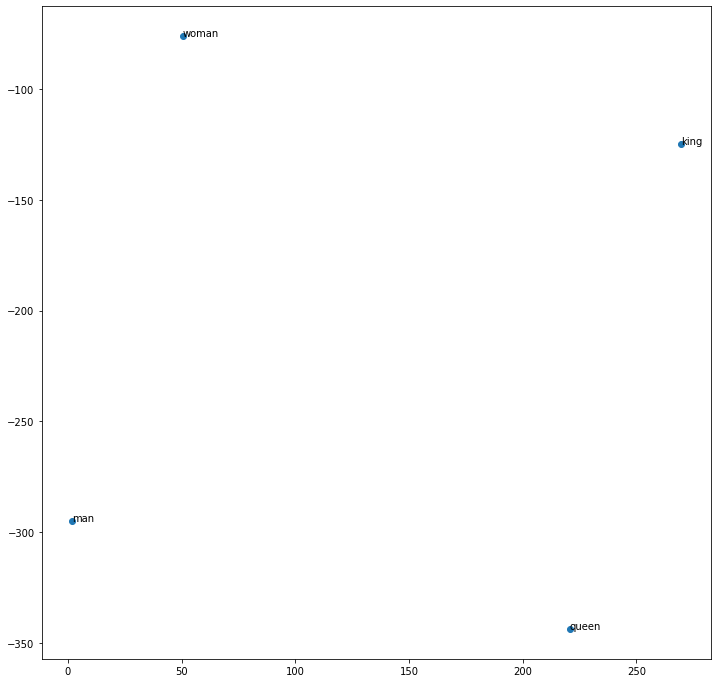

In [36]:
plot_with_matplotlib(x_vals, y_vals, labels, ["king", "man", "queen", "woman"])

## Portuguese embeddings

A number of embeddings for Portuguese are available at [NILC](http://nilc.icmc.usp.br/embeddings), as well as at the [NLX-group](https://github.com/nlx-group/LX-DSemVectors).

In [38]:
from gensim.models import KeyedVectors

# takes a while to load...
# model_pt = KeyedVectors.load_word2vec_format('skip_s100.txt')

# file takes a lot of time to download...

In [39]:
# save model word vectors
# model_pt.save("pt_wv")

In [40]:
# load model word vectors (much faster than the above)
# model_pt = gensim.models.KeyedVectors.load("pt_wv")

In [41]:
# model_pt.most_similar(positive=["cão"])

In [42]:
# model_pt.most_similar(positive=["rei", "mulher"], negative=["homem"])

Make your own experiments!

In [ ]:
# your code here
